In [5]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [6]:
%presentation_style

In [7]:
%%capture

%set_random_seed 12

In [8]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h1>Neural Likelihood and Ratio Estimation</h1>
</div>

In [9]:
import math
import matplotlib.pyplot as plt
import sbi.analysis
import sbi.inference
import sbi.utils
import torch
import warnings

from sbi.utils import process_prior
from torch.distributions import LogNormal
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm.notebook import trange, tqdm

from tfl_training_sbi.config import (
    default_remote_storage,
    get_config,
    root_dir,
)
from tfl_training_sbi.data_utils import (
    SIRSimulation,
    load_sir_data,
)
from tfl_training_sbi.utils_models import save_posterior_obj
from tfl_training_sbi.utils_sir import eval_sir_model

# set manual seed for reproducibility
_ = torch.manual_seed(0)

# ignore user warnings
warnings.filterwarnings("ignore")

# configure storage location
storage = default_remote_storage()
c = get_config(reload=True)

## Outline

 - Recap of Neural Posterior Estimation 
 - Introduction to Neural Likelihood Estimation (NLE)
 - Intro to SBI Python package `sbi`
 - Exercise 
 - Neural Ratio Estimation (NRE)
 - Pros & Cons of all three methods
  

## Recap: the Goal of SBI

- We want to learn the posterior $p(\theta | \mathbf{x})$ of a model $\mathcal{M}$ given some data $\mathbf{x}$
- We do so using Bayes rule: 
    $$
    p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta)
    p(\theta)}{p(\mathbf{x})}
    $$
- However, the Likelihood is usually intractable
- We overcome this challenge by sampling from the joint distribution
  $p(\mathbf{x}, \theta)=p(\mathbf{x}\mid \theta)p(\theta)$ and learn a conditional density estimator


## Recap: Neural Posterior Estimation

- Direct mapping from observations $\mathbf{x}$ to posterior $p(\theta|\mathbf{x})$
- E.g. learning Gaussian mixture, parameterized by neural network

## The Likelihood

- The Likelihood is the conditional probability density of the data given the model parameters, i.e. $p(\mathbf{x}|\theta)$
- This is a density function in $\mathbf{x}$ for fixed $\theta$

## Learning the Likelihood with a Neural Network

- NLE learns $p(\mathbf{x}|\theta)$ instead of $p(\theta|\mathbf{x})$
- Both are conditional density estimation problems ([NB 02](nb_02_conditional_density_estimation.ipynb))
- NLE is a Maximum Likelihood Estimation problem on $\{(\theta, \mathbf{x})_i
  \}^N_{i=1}$ where $\mathcal{M}(\theta_i) = \mathbf{x}_i$
- We can obtain posterior samples via $\hat{p}(\theta \mid \mathbf{x}) \propto p(\theta\mid\mathbf{x})p(\theta)$, using MCMC or variational inference


## Sampling from the NLE Posterior 

- In contrast to NPE, NLE and NRE require MCMC to sample from the posterior
- This should be taken into account when deciding which method to use
- We refer to the training _Introduction to Bayesian Machine Learning_ for a
  more in-depth coverage of accessing the posterior with MCMC


## Why should I use NLE

The goal is to obtain the posterior $p(\theta \mid \mathbf{x})$, why learn
$p(\mathbf{x} \mid \theta)$?

 - Reduced complexity due to factorization for i.i.d. observations 
 - Amortized when increasing the hierarchy 
 - Advantage when $\operatorname{dim}(\theta) \gg \operatorname{dim}(\mathbf{x})$
 - We obtain an emulator: replace expensive simulators
 - No correction for sequential learning 

## Quick Intro to the `sbi` Toolkit

- Open Source Software for SBI; <i class="fa-brands fa-github"></i>[GitHub](https://sbi-dev.github.io/sbi/)
- Implements: ABC, (S)NPE, (S)NLE and (S)NRE, MCMC, variational inference, analysis tools, plotting

In [10]:
# define a uninformative prior
prior = sbi.utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.0]) * 2
)


# define a simple simulator
def example_simulator(theta: torch.tensor):
    return torch.sin(theta) + torch.randn_like(theta) * 0.1


# obtain samples from joint distribution
thetas = prior.sample((10_000,))
x = example_simulator(thetas)


# use the first sample as observation
thetas, theta_obs = thetas[1:, :], thetas[0, :]
x, x_obs = x[1:, :], x[0, :]

In [11]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNPE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(thetas, x).train(training_batch_size=100)
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 155 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

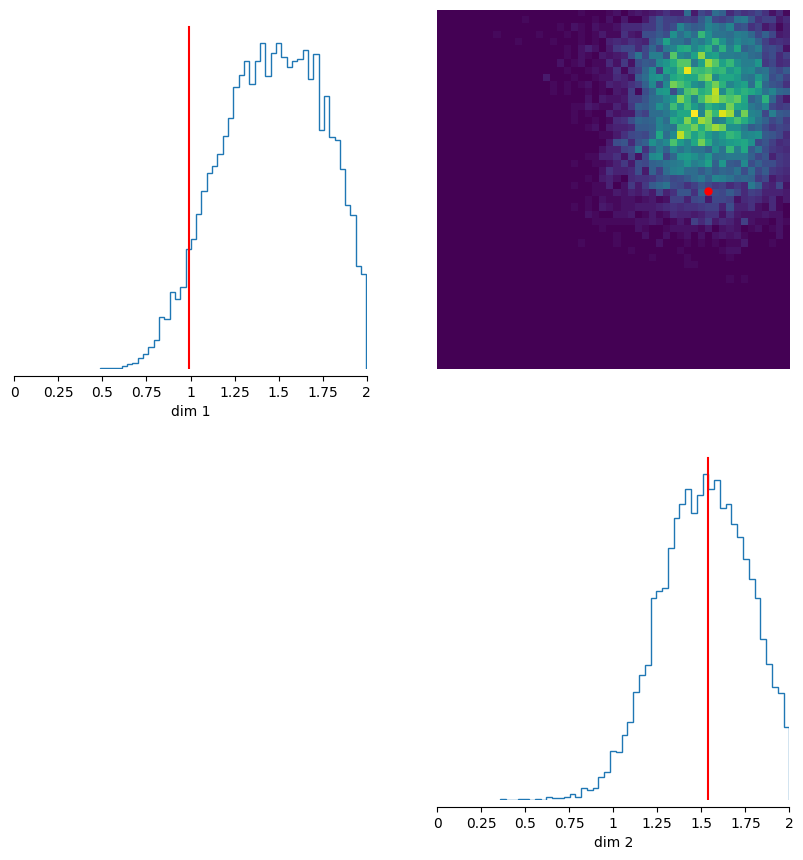

In [12]:
samples = posterior.sample((10_000,), x=x_obs)
sbi.analysis.pairplot(samples=samples, points=theta_obs, points_colors="r", limits=[[0, 2]]*2);

## Exercise: Application of NLE on the SIR Dataset

We will use the same data as in the previous notebook, but now we will use the
neural likelihood estimator to construct the posterior.

**Task 1:** Load the pre-simulated SIR data set from disk and split it into a training and test set (a single pair of "observed" `(theta_o, x_o)`). 

Note that `sbi` standardizes the data automatically. Therefore, the scaling step we performed in notebook 3 can be omitted.


In [13]:
# load the pre-simulated data from disk
data_theta, data_x = load_sir_data(c.data)
data_theta, data_x = torch.tensor(data_theta), torch.tensor(data_x)

# separate the "observed" data from the training data
theta_obs, x_obs = data_theta[0,:], data_x[0,:]
theta_train, x_train = data_theta[1:,:], data_x[1:,:]


**Task 2:** Furthermore, we have to define a suitable prior to the task. As defined in the benchmarking paper by Lueckmann et al., we'll use a LogNormal distribution with the following parameters:
 - $\theta_1 \sim \operatorname{LogNormal}(\log 0.4, 0.5^2)$
 - $\theta_2 \sim \operatorname{LogNormal}(\log 0.125, 0.2^2)$
 
Hint: `sbi` has a method `process_prior` (imported above) that takes as input a list of `torch` distributions and combines the entries in the list into a single joint prior distribution.

In [14]:
prior, _, _ = process_prior([
    LogNormal(
        loc=torch.tensor([math.log(0.4)]),
        scale=torch.tensor([0.5])
    ), 
    LogNormal(
        loc=torch.tensor([math.log(0.125)]),
        scale=torch.tensor([0.2])
    ),
])


**Task 3:** Finally, we can train the NDE. To that end, we have to initialize a SNLE object with the respective prior and method for density estimation. Further, the training data has to be passed to the inference object. The NDE is trained by calling the `.train()` method on the inference object. Feel free to use the above example as blueprint. 

In [15]:
# obtain a posterior approx. via NPE
inference = sbi.inference.SNLE(prior=prior, density_estimator="maf")
density_estimator = inference.append_simulations(theta_train, x_train).train(
    training_batch_size=1024, learning_rate=1e-4, max_num_epochs=200
)
posterior = inference.build_posterior(density_estimator, sample_with="mcmc")


 Training neural network. Epochs trained: 201

## Saving the Inference Object 

The training process of NLE inference objects can take long. Therefore, saving
the inference objects is advised. 

In [16]:
# saving the inference object for possible later use
save_posterior_obj("../notebooks/models/snle_sir.pl", inference)

## Let's Investigate the Learned Posterior 

In order to investigate the quality of approximation, we'll sample a large
number of $\theta$ from the posterior $p(\theta \mid
\mathbf{x}_o)$ using MCMC sampling.

Then, we'll compare the resulting distribution to the actual $\theta^{\ast}$ that was
used to generate $\mathbf{x}_o$.  

**Task 4:** Similar to the example above, use the posterior, conditioned on `x_obs` to sample a large number of $\theta$. Then, plot the resulting samples using the `pairplot` method, provided by the `sbi` toolkit. 

Optional: Use `pairplot` to additionally plot the prior samples as a comparison, e.g., by passing a list of samples `[prior_samples, posterior_sample]`. Use `offdiag="scatter"` option to plot the joint as a scatter plot for better visual comparison.

Running vectorized MCMC with 10 chains:   0%|          | 0/11000 [00:00<?, ?it/s]

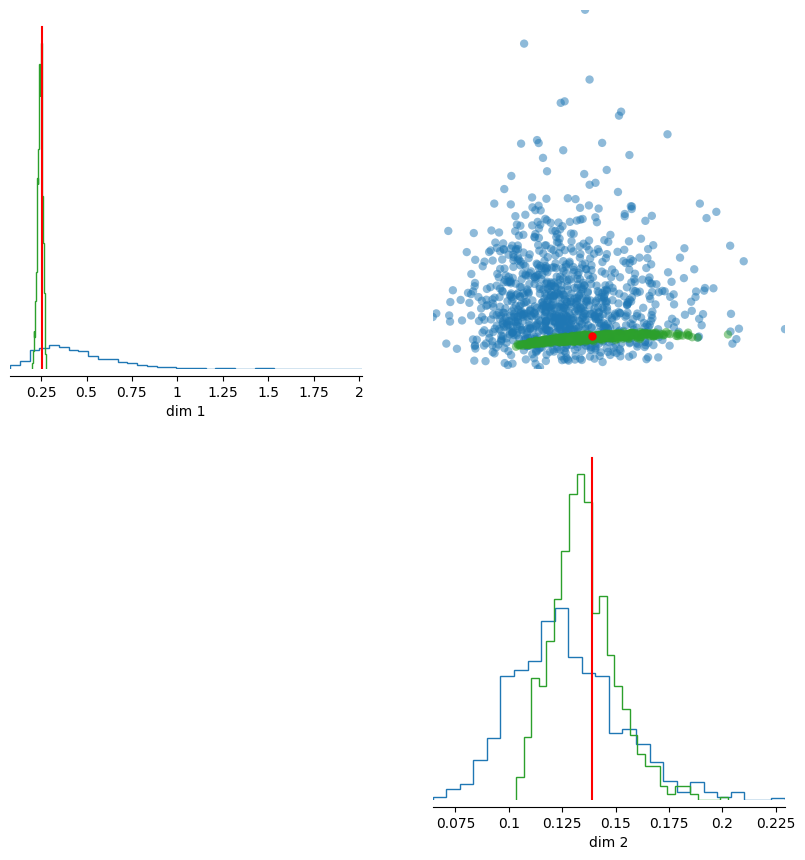

In [19]:
num_samples = 1000
posterior_samples = posterior.sample((num_samples,), x=x_obs, method="slice_np_vectorized", num_chains=10)
prior_samples = theta_train
_ = sbi.analysis.pairplot([prior_samples[:num_samples], posterior_samples], points=theta_obs, points_colors="r", 
                          offdiag="scatter", hist_diag=dict(bins="auto", density=True))


## Neural Ratio Estimation 

- The Likelihood-ratio is a popular test statistic,  

    $$
    r(\mathbf{x} \mid \theta_0, \theta_1) = \frac{p(\mathbf{x} \mid \theta_0)}{p(\mathbf{x} \mid \theta_1)}
    $$
    
- The ratio also appears in the MCMC sampling scheme - having access to it allows us to run MCMC

- idea for SBI: approximate the ratio to enable MCMC.

- Cranmer et al (2015) showed that $r(\mathbf{x}\mid \theta_0, \theta_1)$
  can be approximated by a classifier $d(\mathbf{x}, \theta)$ trained on
  samples from the true $p(\mathbf{x} \mid \theta)$ (label $y=1$) and an arbitrary but fixed
  hypothesis $p(\mathbf{x} \mid \theta_{\text{ref}})$ (label $y=0$).

    $$
    \begin{align}
    d(\mathbf{x}, \theta) &= p(y=1 \mid \mathbf{x}) =
    \frac{p(\mathbf{x}\mid \theta)}{p(\mathbf{x}\mid \theta) + p(\mathbf{x}\mid
    \theta_{\text{ref}})}  \\
    r(\mathbf{x} \mid \theta_0, \theta_1) &= \frac{d(\mathbf{x},
    \theta)}{ 1 - d(\mathbf{x}, \theta) }
    \end{align}
    $$


## Considerations about NRE

- Same concept as NLE but training a classifier rather than a density estimator (can be easier)
- Sampling via MCMC or VI
- Allows learning embeddings for both $x$ and $\theta$. 

## Usage of NRE

- NRE is also implemented in the `sbi` toolkit

    ```python
    inference = sbi.inference.SNRE(prior)
    density_estimator = inference.append_simulations(thetas, x).train()
    posterior = inference.build_posterior(density_estimator)
    ```

## Practical Considerations for NPE vs. NLE and NRE

- NPE enables fully amortized inference: train once, infer for many different $x_o$ in no-time.
- NLE and NRE require MCMC; success depends on the shape and dimension of the posterior 
- Sequential approaches are helpful for high dimensional problems or costly
  simulations. However, SNPE requires a correction term that can make training unstable, SNLE and SNRE require running MCMC for every round.
- All methods allow for embeddings: 
    - Neural networks can take high dimensional inputs easily. 
    - use NPE when $\dim(\mathbf{x}) \gg \dim(\theta)$ and NLE / NRE when $\dim(\mathbf{x})
  \ll \dim(\theta)$ 
- embedding network should take into account the structure of the data. E.g. CNNs for images or RNNs for sequential data.

SBI is an active field of research: new methods and improvements are appearing regularly, e.g., score matching or flow matching methods for SBI. 

`sbi` package is actively developed (and there are other packages too).


## Summary 

| Method | Pros | Cons |
|:---|:---|:---|
|NPE | Amortized inference | Sequential version requires correction |
|NLE | Likelihood factors for i.i.d. samples, easy usage for hierarchical  problems | Requires MCMC, can be constly in higher dimensions |
|NRE | Likelihood factors for i.i.d. samples, training a classifier is easier than training an NDE | Requires MCMC 


## References

- sbi: A toolkit for simulation-based inference;
  [GitHub](https://www.mackelab.org/sbi/credits/)
- Cranmer et al. (2015), _"Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"_
- Lueckmann et al. (2021), _"Benchmarking Simulation-Based Inference"_

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    <h2>Thank you for the attention!</h2>
</div>